In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/article/train_test.csv
/kaggle/input/article-new/test_y.csv
/kaggle/input/article-new/train_y.csv
/kaggle/input/article-new/train_x.csv
/kaggle/input/article-new/train_test.csv
/kaggle/input/article-new/test_x.csv
/kaggle/input/article-new/validate_data.csv


In [2]:
# !pip install transformers
!pip install -q -U transformers accelerate peft bitsandbytes trl datasets

# !pip install -q -U peft
# # !pip install -q -U git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f

# # !pip install -q -U bitsandbytes
# !pip install -q -U bitsandbytes>=0.41.1 --extra-index-url https://jllllll.github.io/bitsandbytes-cuda120/

# # !pip install -q trl
# !pip install -q -U git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e

# !pip install datasets
# datasets==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 68.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.9/503.9 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 23.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.3 MB/s eta 0:00:

In [5]:
# from huggingface_hub import interpreter_login

# interpreter_login()

In [3]:
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split

# # specify GPU
# device = torch.device("cuda")s

In [4]:
# from torch.utils.data import Dataset
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from accelerate import Accelerator
from trl import SFTTrainer
from trl import setup_chat_format
import gc

# Model directory
# model_name = "meta-llama/Llama-3.1-8B-Instruct"
# model_name ="HuggingFaceTB/SmolLM3-3B"
model_name ="Qwen/Qwen3-0.6B"

2025-08-04 00:34:14.032914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754267654.387738      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754267654.489772      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
df = pd.read_csv("/kaggle/input/article/train_test.csv")
df.head()

,Sno,prompt,text,Q1,Q1_score,Q2,Q2_score,Q3,Q3_score,Q4,Q4_score,Q5,Q5_score,Q6,Q6_score,Q7,Q7_score,aggregate_score
0,97,Create a 600-word article on the importance of...,AI: Here's a 600-word article on the importanc...,Yes,0.75,No,0.50,No,0.50,Yes,0.50,Yes,1.0,Yes,0.50,No,0.75,6.0
1,57,Create an 800-word article on the cultural sig...,AI: Certainly! I'll create an 800-word article...,Yes,1.00,Yes,1.00,Yes,1.00,Yes,1.00,Yes,1.0,Yes,1.00,Yes,1.00,10.0
2,98,I need a 900-word article on the latest develo...,"AI: [neutral] Certainly, I can help you with t...",Yes,0.50,No,0.25,No,0.25,No,0.50,Yes,1.0,Yes,0.75,No,0.50,5.0
3,121,Write an 800-word article on the benefits of l...,AI: Here's an 800-word article on the benefits...,Yes,1.00,Yes,1.00,Yes,1.00,Yes,1.00,yes,1.0,Yes,1.00,Yes,1.00,7.0
4,144,Create an 800-word article on the latest advan...,AI: Here's an 800-word article on the latest a...,Yes,1.00,Yes,1.00,Yes,0.75,Yes,0.75,Yes,1.0,Yes,0.75,No,0.75,8.0


In [9]:
df.shape

(162, 18)

In [10]:
train, test  = train_test_split(df, 
                                train_size=140,
                                test_size=20, 
                                random_state=42)

In [11]:
train.columns

Index(['Sno', 'prompt', 'text', 'Q1', 'Q1_score', 'Q2', 'Q2_score', 'Q3',
       'Q3_score', 'Q4', 'Q4_score', 'Q5', 'Q5_score', 'Q6', 'Q6_score', 'Q7',
       'Q7_score', 'aggregate_score'],
      dtype='object')

In [12]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [13]:
def prepare_prompt(datapoint):
    return f"""Analyze the quality for the following Article for Creativity, Interest, 
                Coherance and Relevance. 
                Provide an overall aggregate score on the scale of 1 to 10:
             
             Article: \n {datapoint["text"]}\n
             
             Score: {datapoint["aggregate_score"]}"""
    # return prompt
    

X_train = pd.DataFrame(train.apply(prepare_prompt, axis=1), 
                       columns=["text"])
X_eval = pd.DataFrame(test.apply(prepare_prompt, axis=1), 
                      columns=["text"])

print(f"Training dataset size: {len(X_train)}")
print(f"Validation dataset size: {len(X_eval)}")

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

Training dataset size: 140
Validation dataset size: 20


In [14]:
X_train[:1]

,text
75,Analyze the quality for the following Article ...


In [15]:
device

device(type='cuda', index=0)

In [16]:
# Clear CUDA cache and garbage collect
torch.cuda.empty_cache()
gc.collect()

# Set up accelerator
accelerator = Accelerator()
device = accelerator.device

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True
)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load model with quantization
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        torch_dtype=torch.float16,
        trust_remote_code=True,
        # device_map="auto"  # Enable automatic device mapping
        # device_map={'':torch.cuda.current_device()}
        device_map =None
    ).to(device)
    
    # Enable gradient checkpointing for memory efficiency
    model.gradient_checkpointing_enable()
    
    print("Model loaded successfully!")
    print(f"Model is using device: {next(model.parameters()).device}")
    
except Exception as e:
    print(f"Error loading model: {str(e)}")
    raise

model.config.use_cache = False
model.config.pretraining_tp = 1

# Optional: Print model memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"GPU Memory cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

print_gpu_memory()

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Model loaded successfully!
Model is using device: cuda:0
GPU Memory allocated: 513.97 MB
GPU Memory cached: 1258.00 MB


In [17]:
output_dir="trained_weigths"

peft_config = LoraConfig(
        lora_alpha=16, 
        lora_dropout=0.1,
        r=64,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=5,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=1,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="tensorboard",                  # report metrics to tensorboard
    # evaluation_strategy="epoch"               # save checkpoint every epoch
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    # dataset_text_field="text",
    # tokenizer=tokenizer,
    # max_seq_length=1024,
    # packing=False,
    # dataset_kwargs={
    #     "add_special_tokens": False,
    #     "append_concat_token": False,
    # }
)

Adding EOS to train dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
# Train model
trainer.train()

Step,Training Loss
1,1.103700
2,1.034700
3,1.118000
4,0.868900
5,0.894000
6,0.813600
7,0.801600
8,0.812000
9,0.818200
10,0.802200


TrainOutput(global_step=45, training_loss=0.7547656112247043, metrics={'train_runtime': 934.5061, 'train_samples_per_second': 0.749, 'train_steps_per_second': 0.048, 'total_flos': 2051022536048640.0, 'train_loss': 0.7547656112247043})

In [19]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_weigths/tokenizer_config.json',
 'trained_weigths/special_tokens_map.json',
 'trained_weigths/chat_template.jinja',
 'trained_weigths/vocab.json',
 'trained_weigths/merges.txt',
 'trained_weigths/added_tokens.json',
 'trained_weigths/tokenizer.json')

In [24]:
from tensorflow.python.summary.summary_iterator import summary_iterator

tf_path = "/kaggle/working/trained_weigths/runs/Aug04_00-35-53_358058544f8c/events.out.tfevents.1754267762.358058544f8c.36.0"
err = list()
train_loss_l = list()
tag_l = list()
for e in summary_iterator(tf_path):
    for v in e.summary.value:
        # print (v)
        if v.tag not in tag_l:
            tag_l.append(v.tag)
        if v.tag == 'train/loss' or v.tag == 'accuracy':
            err.append(v.simple_value)
        if v.tag =="train/train_loss":
            train_loss_l.append(v.simple_value)

In [23]:
print (tag_l)

['args/text_summary', 'model_config/text_summary', 'train/loss', 'train/grad_norm', 'train/learning_rate', 'train/num_tokens', 'train/mean_token_accuracy', 'train/epoch', 'train/train_runtime', 'train/train_samples_per_second', 'train/train_steps_per_second', 'train/total_flos', 'train/train_loss']


In [26]:
err

[1.103700041770935,
 1.0347000360488892,
 1.1180000305175781,
 0.8689000010490417,
 0.8939999938011169,
 0.8136000037193298,
 0.8015999794006348,
 0.8119999766349792,
 0.8181999921798706,
 0.8022000193595886,
 0.775600016117096,
 0.8237000107765198,
 0.7371000051498413,
 0.8349000215530396,
 0.6862000226974487,
 0.7962999939918518,
 0.8008999824523926,
 0.6935999989509583,
 0.7545999884605408,
 0.7166000008583069,
 0.7498999834060669,
 0.70169997215271,
 0.694599986076355,
 0.8551999926567078,
 0.6972000002861023,
 0.6672999858856201,
 0.7936000227928162,
 0.73580002784729,
 0.6761000156402588,
 0.6492000222206116,
 0.7020999789237976,
 0.7182999849319458,
 0.7027999758720398,
 0.6772000193595886,
 0.6171000003814697,
 0.6676999926567078,
 0.6927000284194946,
 0.6481999754905701,
 0.6467000246047974,
 0.6717000007629395,
 0.6736999750137329,
 0.7271000146865845,
 0.6773999929428101,
 0.6392999887466431,
 0.59579998254776]

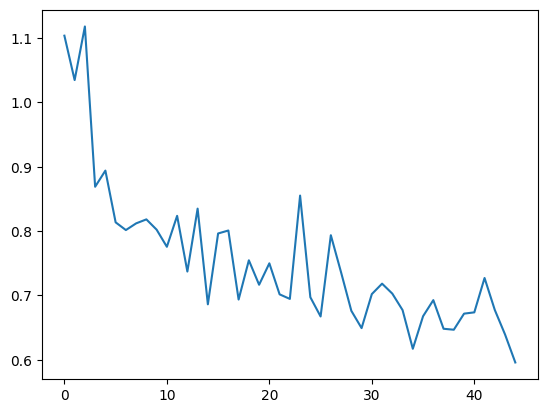

In [27]:
import matplotlib.pyplot as plt

plt.plot(err)
# plt.plot(train_loss_l)

In [28]:
# Clear CUDA cache and garbage collect
torch.cuda.empty_cache()
gc.collect()

87

In [65]:
# del [model, tokenizer, peft_config, trainer, train_data, eval_data, bnb_config, training_arguments]
# del [df, X_train, X_eval]
# del [TrainingArguments, SFTTrainer, LoraConfig, BitsAndBytesConfig]

In [66]:
# for _ in range(100):
#     torch.cuda.empty_cache()
#     gc.collect()

In [29]:
!nvidia-smi

Mon Aug  4 01:01:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             36W /   70W |    2237MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [30]:
# PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation. 

import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [31]:
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer
import torch

# model_name ="HuggingFaceTB/SmolLM3-3B"
# model_name = "meta-llama/Llama-3.1-8B-Instruct"
finetuned_model = "./trained_weigths/"
compute_dtype = getattr(torch, "float16")
tokenizer = AutoTokenizer.from_pretrained(finetuned_model, 
                                          trust_remote_code=True
                                          , output_hidden_states=True)

model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=compute_dtype,
     return_dict=True,
     low_cpu_mem_usage=True,
     # device_map=device,
     # output_hidden_states=True
   device_map =None
    ).to(device)

merged_model = model.merge_and_unload()
merged_model.save_pretrained("merged_model",safe_serialization=True, max_shard_size="2GB")
tokenizer.save_pretrained("merged_model")

('merged_model/tokenizer_config.json',
 'merged_model/special_tokens_map.json',
 'merged_model/chat_template.jinja',
 'merged_model/vocab.json',
 'merged_model/merges.txt',
 'merged_model/added_tokens.json',
 'merged_model/tokenizer.json')

In [33]:
df_val = pd.read_csv("/kaggle/input/article-new/validate_data.csv")
df_val.head()

,Sno,prompt,text,Q1,Q1_score,Q2,Q2_score,Q3,Q3_score,Q4,Q4_score,Q5,Q5_score,Q6,Q6_score,Q7,Q7_score,aggregate_score
0,20,Create a 700-word article on the benefits of r...,AI: Certainly! I'll generate a 700-word articl...,Yes,0.75,Yes,0.75,Yes,0.5,Yes,0.75,Yes,0.75,Yes,0.75,No,0.75,7.0
1,43,Create a 600-word article on the history of av...,AI: Certainly! Here's a 600-word article on th...,Yes,1.00,No,0.00,Yes,1.0,Yes,1.00,Yes,1.00,Yes,1.00,No,0.00,7.0
2,154,I need an 800-word article on the impact of so...,"AI: Certainly, I can help you with that articl...",Yes,0.75,Yes,0.75,No,0.5,No,0.50,Yes,0.75,No,0.50,No,0.50,7.0
3,79,Write a 900-word article on the importance of ...,AI: Here's a 900-word article on the importanc...,Yes,0.50,No,0.50,No,0.5,No,0.50,Yes,0.50,Yes,0.25,No,0.25,6.0
4,146,Write a 900-word article on the importance of ...,"AI: Certainly, I'll generate a 900-word articl...",Yes,0.75,Yes,0.75,No,0.5,No,0.50,Yes,0.75,No,0.50,No,0.50,7.0


In [34]:
def test_prepare_prompt(datapoint):
    return f"""Analyze the quality for the following Article for Creativity, Interest, 
                Coherance and Relevance. 
                Provide an overall aggregate score on the scale of 1 to 10:
             
             Article: \n {datapoint["text"]}\n
             
             Score:"""
    # return prompt
    

X_val = pd.DataFrame(df_val.apply(test_prepare_prompt, axis=1), 
                       columns=["text"])
# X_val = Datasets.frompandas(X_val)

In [36]:
X_val.columns

Index(['text'], dtype='object')

In [37]:
from tqdm import tqdm
from transformers import pipeline

def predict(test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_val))):
        prompt = X_val.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        # max_new_tokens = 1, 
                        # temperature = 0.0,
                       )
        # input_ids = tokenizer(test)
        # outputs = model(input_ids) # This returns a tuple
        # last_hidden_state = outputs[0]
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("=")[-1]
        y_pred.append(answer)
    return y_pred

In [38]:
device

device(type='cuda')

In [39]:
y_pred = predict(X_val, merged_model, tokenizer)


100%|██████████| 18/18 [03:52<00:00, 12.93s/it]


In [44]:
# for idx in range(len (y_pred)):
#     print ( y_pred[idx])
#     break

In [41]:
df1 = pd.DataFrame(y_pred)
df1.head()

,0
0,Analyze the quality for the following Article ...
1,Analyze the quality for the following Article ...
2,Analyze the quality for the following Article ...
3,Analyze the quality for the following Article ...
4,Analyze the quality for the following Article ...


In [42]:
df1.to_csv("df1_predict.csv", index = False)

In [ ]:
# befor fine-tune

In [43]:
model_name

'Qwen/Qwen3-0.6B'

In [46]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# model_name = 'Qwen/Qwen3-0.6B'
pre_tokenizer = AutoTokenizer.from_pretrained(model_name)
pre_model = AutoModelForCausalLM.from_pretrained(model_name,   device_map =None
    ).to(device)


In [47]:
from tqdm import tqdm

all_pred = []
for idx, row in tqdm(X_val.iterrows()):
    input_prompt = row.iloc[0]
    messages = [
        {
            "role": "user",
            "content": input_prompt
        }
    ]
    
    inputs = pre_tokenizer.apply_chat_template(
        messages,
        enable_thinking=False, # True works as well, your choice!
        # xml_tools=tools,
        add_generation_prompt=True,
        tokenize=True,
        return_tensors="pt"
    )
    
    outputs = pre_model.generate(inputs)
    pred = pre_tokenizer.decode(outputs[0])
    all_pred.append(pred)

0it [00:00, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
18it [06:07, 20.39s/it]


In [48]:
print (len(all_pred))

18


In [49]:
df1=pd.DataFrame(all_pred)
df1.to_csv("before_article.csv", index=False)